#1. Mounting Google drive

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
VIDEO_PATH = '/content/drive/MyDrive/Cow Dataset/Videos/'

In [3]:
import sys 

sys.path.append('/content/drive/MyDrive/keypoint_rcnn_training_pytorch')

#2. Importing

In [4]:
import os,cv2,matplotlib.pyplot as plt 

import torch 
from torch.utils.data import Dataset, DataLoader

import torchvision 
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

from ClassDataset import ClassDataset
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [5]:
import numpy as np
import pandas as pd
import datetime

#3. Loading Pretrained weights

In [6]:
keypoints_classes_ids2names = {0: 'lower', 1: 'upper'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 3, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        

In [7]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
wt_path='/content/drive/MyDrive/keypoint_rcnn_training_pytorch/keypointsrcnn_weightse100.pth'

In [10]:
model = get_model(num_keypoints = 2,weights_path=wt_path)
model.to(device)

In [11]:
len(os.listdir(VIDEO_PATH))

96

In [12]:
root_video_path='/content/drive/MyDrive/Cow Dataset/Videos/'
videos_paths= os.listdir(VIDEO_PATH)


In [13]:
print(videos_paths)

['sequence0.mp4', 'sequence1.mp4', 'sequence2.mp4', 'sequence3.mp4', 'sequence4.mp4', 'sequence5.mp4', 'sequence6.mp4', 'sequence7.mp4', 'sequence8.mp4', 'sequence9.mp4', 'sequence10.mp4', 'sequence11.mp4', 'sequence12.mp4', 'sequence13.mp4', 'sequence14.mp4', 'sequence15.mp4', 'sequence16.mp4', 'sequence17.mp4', 'sequence18.mp4', 'sequence19.mp4', 'sequence20.mp4', 'sequence21.mp4', 'sequence22.mp4', 'sequence23.mp4', 'sequence24.mp4', 'sequence25.mp4', 'sequence26.mp4', 'sequence27.mp4', 'sequence28.mp4', 'sequence29.mp4', 'sequence30.mp4', 'sequence31.mp4', 'sequence32.mp4', 'sequence33.mp4', 'sequence34.mp4', 'sequence35.mp4', 'sequence36.mp4', 'sequence37.mp4', 'sequence38.mp4', 'sequence39.mp4', 'sequence40.mp4', 'sequence41.mp4', 'sequence42.mp4', 'sequence43.mp4', 'sequence44.mp4', 'sequence45.mp4', 'sequence46.mp4', 'sequence47.mp4', 'sequence48.mp4', 'sequence49.mp4', 'sequence50.mp4', 'sequence51.mp4', 'sequence52.mp4', 'sequence53.mp4', 'sequence54.mp4', 'sequence55.mp4', '

In [14]:
def annotatevideo(video_path):
    vidcap = cv2.VideoCapture(video_path) 
    success,image = vidcap.read()
    frame_count=1
    while success:
        frame_count+=1
        success,image = vidcap.read()
    print("No. of frames in"+video_path,frame_count) 
    return None

In [15]:
def get_frame_count_and_fps(videos_paths):
  frame_counts = []
  fpss=[]

  for video_path in videos_paths:
    #annotatevideo(video_path)
    vidcap = cv2.VideoCapture(root_video_path+video_path) 
    success,image = vidcap.read()
    # while success:
    #     frame_count+=1
    #     success,image = vidcap.read()
    frame_count = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    #print("No. of frames in "+video_path,frame_count)   
    frame_counts.append(frame_count)
    fpss.append(fps) 
  print(frame_counts)
  print(fpss)
  df= pd.DataFrame()
  df['frame_count'] = pd.Series(frame_counts)
  df['fps'] = pd.Series(fpss)
  return df
    

In [16]:
vid_data = get_frame_count_and_fps(videos_paths)

[40.0, 20.0, 22.0, 26.0, 24.0, 25.0, 21.0, 60.0, 48.0, 53.0, 60.0, 46.0, 48.0, 53.0, 50.0, 50.0, 53.0, 53.0, 48.0, 50.0, 50.0, 48.0, 55.0, 48.0, 48.0, 58.0, 43.0, 50.0, 46.0, 53.0, 48.0, 48.0, 53.0, 50.0, 73.0, 73.0, 60.0, 65.0, 62.0, 58.0, 55.0, 55.0, 28.0, 57.0, 17.0, 26.0, 25.0, 24.0, 24.0, 25.0, 26.0, 19.0, 37.0, 68.0, 62.0, 50.0, 57.0, 60.0, 50.0, 50.0, 55.0, 58.0, 55.0, 53.0, 55.0, 65.0, 53.0, 55.0, 55.0, 53.0, 55.0, 63.0, 55.0, 55.0, 65.0, 53.0, 57.0, 50.0, 62.0, 45.0, 53.0, 60.0, 58.0, 53.0, 55.0, 50.0, 40.0, 45.0, 53.0, 53.0, 57.0, 58.0, 47.0, 55.0, 50.0, 53.0]
[25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 23.976023976023978, 60.0, 29.97002997002997, 29.97002997002997, 29.97002997002997, 29.97002997002997, 29.97002997002997, 29.97002997002997, 29.97002997002997, 29.97002997

In [17]:
def calc_duration(row):
    return row['frame_count']/row['fps']

In [18]:
vid_data['duration'] = vid_data.apply(lambda row : calc_duration(row),axis=1)

In [19]:
def rename_files(video_paths):
    i=0
    for video_path in video_paths:
        os.rename(root_video_path+video_path,root_video_path+"sequence"+str(i))
        i+=1 


In [20]:
#rename_files(videos_paths)

In [21]:
vid_data.head()

,frame_count,fps,duration
0,40.0,25.0,1.60
1,20.0,25.0,0.80
2,22.0,25.0,0.88
3,26.0,25.0,1.04
4,24.0,25.0,0.96


In [22]:
vid_data[vid_data['duration']<1.6].sort_values(by=['duration'],ascending=False)

,frame_count,fps,duration
52,37.0,29.970030,1.234567
35,73.0,60.000000,1.216667
34,73.0,60.000000,1.216667
42,28.0,23.976024,1.167833
53,68.0,60.000000,1.133333
...,...,...,...
87,45.0,60.000000,0.750000
26,43.0,60.000000,0.716667
86,40.0,60.000000,0.666667
51,19.0,29.970030,0.633967


In [23]:
vid_data[vid_data['duration']<1.6].describe()

,frame_count,fps,duration
count,95.000000,95.000000,95.000000
mean,49.168421,54.565329,0.899950
std,12.715925,12.185635,0.116695
min,17.000000,23.976024,0.567233
25%,48.000000,60.000000,0.833333
50%,53.000000,60.000000,0.883333
75%,56.000000,60.000000,0.963333
max,73.000000,60.000000,1.234567


<AxesSubplot:>

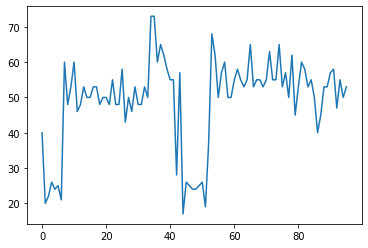

In [24]:
vid_data['frame_count'].plot()

<AxesSubplot:>

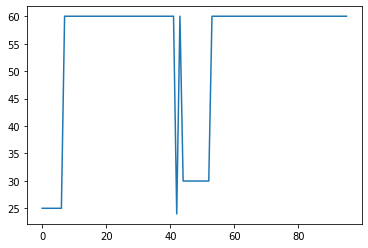

In [25]:
vid_data['fps'].plot()

In [26]:
rows_with_less_fps=vid_data[vid_data['fps']<60].index.tolist()

In [27]:
vid_data_60=vid_data.drop(index=rows_with_less_fps)

In [28]:
vid_data_60.describe()

,frame_count,fps,duration
count,79.000000,79.0,79.000000
mean,54.202532,60.0,0.903376
std,6.212848,0.0,0.103547
min,40.000000,60.0,0.666667
25%,50.000000,60.0,0.833333
50%,53.000000,60.0,0.883333
75%,57.500000,60.0,0.958333
max,73.000000,60.0,1.216667


In [29]:
def vid_to_img(c,path):
    filename = path[:-4]
    vidcap = cv2.VideoCapture(root_video_path+path) 
    success,image = vidcap.read() 
    print(filename)
    count =0 
    #success = True 
    #print(image)
    dest=""
    while success:
        dest="/content/drive/MyDrive/imgfromvids3/"+str(c)+"_"+filename+"_"+str(count)+".jpg"
        #print(dest)
        if count%7==0 or count%8==0:
            cv2.imwrite(dest,image) 
        success,image = vidcap.read() 
        if cv2.waitKey(10) ==27:
            break 
        count+=1

In [30]:
#for i in range(1,len(videos_paths)):
    #vid_to_img(i,videos_paths[i])

In [34]:
vid_data_60.size

237

In [35]:
vid_data.size

288

In [37]:
df = pd.DataFrame()

In [ ]:
for